In [1]:
from __future__ import print_function # Use a function definition from future version (say 3.x from 2.7 interpreter)
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import sys
import os
import cntk as C

%matplotlib inline

In [2]:
np.random.seed(0)
# Define the data dimensions
input_dim = 784
num_output_classes = 10

In [3]:
def create_reader(path, is_training, input_dim, num_label_classes):
    
    labelStream = C.io.StreamDef(field='labels', shape=num_label_classes, is_sparse=False)
    featureStream = C.io.StreamDef(field='features', shape=input_dim, is_sparse=False)
    
    deserializer = C.io.CTFDeserializer(path, C.io.StreamDefs(labels = labelStream, features = featureStream))
            
    return C.io.MinibatchSource(deserializer,
       randomize = is_training, max_sweeps = C.io.INFINITELY_REPEAT if is_training else 1)

In [4]:

input = C.input_variable(input_dim)
label= C.input_variable(num_output_classes)
num_hidden_layers=2
num_nodes_layer=[400,400]

** MODEL Creation **

In [5]:
def create_model(features):
    with C.layers.default_options(init=C.glorot_uniform(),activation=C.ops.relu):
        h=features
        for i in range(1,num_hidden_layers):
            c=C.layers.Dense(num_nodes_layer[i])(h)
            h=c
        return C.layers.Dense(10,activation=None)(h)
z=create_model(input/255.0)

In [6]:
loss=C.cross_entropy_with_softmax(z,label)
label_error=C.classification_error(z,label)

lr_schedule=C.learning_rate_schedule(0.2,C.UnitType.minibatch)
learner=C.sgd(z.parameters,lr_schedule)
trainer=C.Trainer(z,(loss,label_error),[learner])

In [7]:

data_dir=os.path.join("data","MNIST")
train_file = os.path.join(data_dir, "Train-28x28_cntk_text.txt")
test_file = os.path.join(data_dir, "Test-28x28_cntk_text.txt")

minibatch_size = 64
num_samples_per_sweep = 60000
num_sweeps_to_train_with = 10
num_minibatches_to_train = (num_samples_per_sweep * num_sweeps_to_train_with) / minibatch_size


def moving_average(a, w=5):
    if len(a)< w:
        return a[:]
    return [val if idx < w else sum(a[(idx-w):idx])/w for idx, val in enumerate(a)]

def print_training_progress(trainer, mb, frequency, verbose=1):
    training_loss = "NA"
    eval_error = "NA"

    if mb%frequency == 0:
        training_loss = trainer.previous_minibatch_loss_average
        eval_error = trainer.previous_minibatch_evaluation_average
        if verbose: 
            print ("Minibatch: {0}, Loss: {1:.4f}, Error: {2:.2f}%".format(mb, training_loss, eval_error*100))
        
    return mb, training_loss, eval_error

In [8]:


reader_train=create_reader(train_file,True,input_dim,10)
input_map={
    label:reader_train.streams.labels,
    input:reader_train.streams.features
}
training_progress_output_freq=500

plotdata={"batchsize":[],"loss":[],"error":[]}
for i in range(int(num_minibatches_to_train)):
    
    # Read a mini batch from the training data file
    data = reader_train.next_minibatch(minibatch_size, input_map = input_map)
    
    trainer.train_minibatch(data)
    batchsize, loss, error = print_training_progress(trainer, i, training_progress_output_freq, verbose=1)
    
    if not (loss == "NA" or error =="NA"):
        plotdata["batchsize"].append(batchsize)
        plotdata["loss"].append(loss)
        plotdata["error"].append(error)



Minibatch: 0, Loss: 2.3710, Error: 89.06%
Minibatch: 500, Loss: 0.1703, Error: 4.69%
Minibatch: 1000, Loss: 0.1292, Error: 3.12%
Minibatch: 1500, Loss: 0.1321, Error: 7.81%
Minibatch: 2000, Loss: 0.0439, Error: 1.56%
Minibatch: 2500, Loss: 0.0239, Error: 0.00%
Minibatch: 3000, Loss: 0.0393, Error: 1.56%
Minibatch: 3500, Loss: 0.1000, Error: 3.12%
Minibatch: 4000, Loss: 0.0218, Error: 1.56%
Minibatch: 4500, Loss: 0.0658, Error: 3.12%
Minibatch: 5000, Loss: 0.0497, Error: 1.56%
Minibatch: 5500, Loss: 0.0452, Error: 1.56%
Minibatch: 6000, Loss: 0.0132, Error: 0.00%
Minibatch: 6500, Loss: 0.0131, Error: 0.00%
Minibatch: 7000, Loss: 0.0808, Error: 3.12%
Minibatch: 7500, Loss: 0.0162, Error: 0.00%
Minibatch: 8000, Loss: 0.0049, Error: 0.00%
Minibatch: 8500, Loss: 0.0180, Error: 0.00%
Minibatch: 9000, Loss: 0.0275, Error: 1.56%


_PLOTTING_

In [9]:
# Read the training data
reader_test = create_reader(test_file, False, input_dim, num_output_classes)

test_input_map = {
    label  : reader_test.streams.labels,
    input  : reader_test.streams.features,
}

# Test data for trained model
test_minibatch_size = 512
num_samples = 10000
num_minibatches_to_test = num_samples // test_minibatch_size
test_result = 0.0

for i in range(num_minibatches_to_test):
    
    # We are loading test data in batches specified by test_minibatch_size
    # Each data point in the minibatch is a MNIST digit image of 784 dimensions 
    # with one pixel per dimension that we will encode / decode with the 
    # trained model.
    data = reader_test.next_minibatch(test_minibatch_size,
                                      input_map = test_input_map)

    eval_error = trainer.test_minibatch(data)
    test_result = test_result + eval_error

# Average of evaluation errors of all test minibatches
print("Average test error: {0:.2f}%".format(test_result*100 / num_minibatches_to_test))

Average test error: 2.03%


[7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4, 9, 6, 6, 5, 4]
[7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4, 9, 6, 6, 5, 4]
9


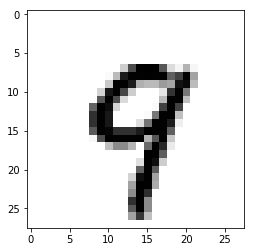

In [10]:
out=C.softmax(z)
reader_eval = create_reader(test_file, False, input_dim, num_output_classes)

eval_minibatch_size = 25
eval_input_map ={input: reader_eval.streams.features,
                 label: reader_eval.streams.labels} 

data = reader_eval.next_minibatch(eval_minibatch_size, input_map = eval_input_map)

img_label = data[label].asarray()

img_data = data[input].asarray()

predicted_label_prob = [out.eval(img_data[i]) for i in range(len(img_data))]


pred=[np.argmax(predicted_label_prob[i]) for i in range(len(predicted_label_prob))]
actual_label=[np.argmax(img_label[i]) for i in range(len(img_label))]


print(pred[:25])
print(actual_label)

i=12
plt.imshow(img_data[12].reshape(28,28),cmap="gray_r")
print(pred[i])

8


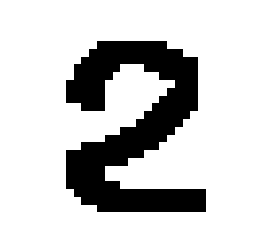

In [11]:
from IPython.display import Image
from scipy import misc
path=os.path.join("MysteryNumberD.bmp")
image=misc.imread(path,flatten=0)
image=image.reshape(1,784)
ans=out.eval(image.astype(np.float32))
print(np.argmax(ans))
plt.axis("off")
plt.imshow(image.reshape(28,28),cmap="gray_r")

    
